In [1]:

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.sample import sample_gen
from scipy.spatial import cKDTree
import pyodbc

In [2]:
# ===============================================================
# 1. Load Fire Dataset & land Boundaries
# ===============================================================

fires = pd.read_csv("../data/processed/Fire/combined_fire_data_2024.csv")

land = (
    gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp")
    .to_crs(4326)
)

In [3]:

# ===============================================================
# 2. Build Regular Grid Over the Study Area
# ===============================================================
grid_resolution = 0.005  # degrees (~550m)

lat_min, lat_max = fires['latitude'].min(), fires['latitude'].max()
lon_min, lon_max = fires['longitude'].min(), fires['longitude'].max()

# Slight buffer
lat_min -= grid_resolution
lat_max += grid_resolution
lon_min -= grid_resolution
lon_max += grid_resolution

# Generate grid
lats = np.arange(lat_min, lat_max, grid_resolution)
lons = np.arange(lon_min, lon_max, grid_resolution)

grid_points = [{'latitude': lat, 'longitude': lon} 
               for lat in lats for lon in lons]

grid_df = pd.DataFrame(grid_points)
grid_gdf = gpd.GeoDataFrame(
    grid_df,
    geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
    crs="EPSG:4326"
)

# Keep only grid points inside Algeria & Tunisia
grid_gdf = gpd.sjoin(grid_gdf, land[['geometry']], how="inner", predicate="within")
grid_gdf.drop(columns=["index_right"], inplace=True)

grid_df = grid_gdf[['latitude', 'longitude']].copy()
grid_df['fire'] = 0

In [4]:

# ===============================================================
# 3. Label fire / non-fire using KDTree (very fast)
# ===============================================================
fire_coords = fires[['latitude', 'longitude']].values
tree = cKDTree(fire_coords)

tolerance = grid_resolution / 2
distances, _ = tree.query(grid_df[['latitude', 'longitude']].values,
                          distance_upper_bound=tolerance)

grid_df.loc[distances < tolerance, 'fire'] = 1

print("Grid cells:", len(grid_df))
print("Fire cells:", grid_df.fire.sum())
print("Non-fire cells:", (grid_df.fire == 0).sum())

grid_df.to_csv("../data/processed/Fire/fnf.csv", index=False)


Grid cells: 9019632
Fire cells: 4582
Non-fire cells: 9015050


In [5]:
# ===============================================================
# 3.1 Non-fire downsampling (choose ONE method mnb3d)
# ===============================================================


In [6]:
def spatial_stratified_sampling(grid_df, tile_size=0.05, frac=0.01):
    """
    Spatially stratified sampling of non-fire cells.

    tile_size : size of spatial tiles (degrees)
    frac      : percentage of non-fire cells to keep inside each tile
    """

    df = grid_df.copy()

    # Keep ALL fire cells
    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]

    # Create tile indices
    nonfire_df["tile_lat"] = (nonfire_df.latitude // tile_size).astype(int)
    nonfire_df["tile_lon"] = (nonfire_df.longitude // tile_size).astype(int)

    sampled_list = []

    # Sample inside each tile independently
    for (tlat, tlon), group in nonfire_df.groupby(["tile_lat", "tile_lon"]):
        sampled = group.sample(
            frac=frac, 
            random_state=42
        )
        sampled_list.append(sampled)

    sampled_nonfire = pd.concat(sampled_list)

    # Final merged dataset
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)

    print("Spatial Stratified Sampling")
    print("Original non-fire:", len(nonfire_df))
    print("Sampled non-fire:", len(sampled_nonfire))
    print("Final dataset:", len(sampled_df))

    return sampled_df

#grid_df = spatial_stratified_sampling(grid_df, tile_size=0.05, frac=0.10)


In [7]:


def distance_based_sampling(grid_df):
    df = grid_df.copy()

    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]

    # Compute distance to nearest fire point
    fire_coords = fire_df[["latitude", "longitude"]].values
    tree = cKDTree(fire_coords)

    dists, _ = tree.query(nonfire_df[["latitude", "longitude"]].values)
    nonfire_df["dist"] = dists

    # Define distance bins and sampling fractions
    bins = [0, 0.02, 0.05, 0.20, np.inf]
    fracs = [1.0, 0.4, 0.1, 0.01]   # keep many near fires, few far away

    nonfire_df["bin"] = np.digitize(nonfire_df["dist"], bins)

    sampled_list = []
    for b, frac in zip(range(1, 5), fracs):
        group = nonfire_df[nonfire_df.bin == b]
        sampled = group.sample(
            frac=frac,
            random_state=42
        )
        sampled_list.append(sampled)

    sampled_nonfire = pd.concat(sampled_list)

    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)

    print("Distance-based Sampling")
    print("Original non-fire:", len(nonfire_df))
    print("Sampled non-fire:", len(sampled_nonfire))
    print("Final dataset:", len(sampled_df))

    return sampled_df

#grid_df = distance_based_sampling(grid_df)


In [8]:
from sklearn.cluster import MiniBatchKMeans

def kmeans_environmental_sampling(grid_df, n_clusters=200, frac=0.1):
    df = grid_df.copy()

    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]

    # Features for clustering (lat/lon only OR add elevation/climate)
    features = nonfire_df[["latitude", "longitude"]].values

    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=4096
    )
    labels = km.fit_predict(features)
    nonfire_df["cluster"] = labels

    sampled_list = []
    for c, group in nonfire_df.groupby("cluster"):
        sampled = group.sample(
            frac=frac,
            random_state=42
        )
        sampled_list.append(sampled)

    sampled_nonfire = pd.concat(sampled_list)
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)

    print("KMeans Sampling")
    print("Original non-fire:", len(nonfire_df))
    print("Sampled non-fire:", len(sampled_nonfire))
    print("Final dataset:", len(sampled_df))

    return sampled_df

#grid_df = kmeans_environmental_sampling(grid_df, n_clusters=200, frac=0.10)


In [9]:
def adaptive_grid_sampling(grid_df, base_tile=0.02):
    df = grid_df.copy()

    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]

    # Tile index
    nonfire_df["tile_lat"] = (nonfire_df.latitude // base_tile).astype(int)
    nonfire_df["tile_lon"] = (nonfire_df.longitude // base_tile).astype(int)

    sampled_list = []

    for (tlat, tlon), group in nonfire_df.groupby(["tile_lat", "tile_lon"]):
        size = len(group)

        # Dynamic sampling rate:
        if size < 200: frac = 1.0
        elif size < 800: frac = 0.5
        elif size < 3000: frac = 0.15
        else: frac = 0.03

        sampled = group.sample(
            frac=frac,
            random_state=42
        )
        sampled_list.append(sampled)

    sampled_nonfire = pd.concat(sampled_list)
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)

    print("Adaptive Density Sampling")
    print("Original non-fire:", len(nonfire_df))
    print("Sampled non-fire:", len(sampled_nonfire))
    print("Final dataset:", len(sampled_df))

    return sampled_df

#grid_df = adaptive_grid_sampling(grid_df)



In [10]:
# Choose ONE 
grid_df = spatial_stratified_sampling(grid_df, tile_size=0.05, frac=0.01)
# grid_df = distance_based_sampling(grid_df)
# grid_df = kmeans_environmental_sampling(grid_df)
# grid_df = adaptive_grid_sampling(grid_df)


C:\Users\lemon\AppData\Local\Temp\ipykernel_2892\2123236654.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonfire_df["tile_lat"] = (nonfire_df.latitude // tile_size).astype(int)
C:\Users\lemon\AppData\Local\Temp\ipykernel_2892\2123236654.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonfire_df["tile_lon"] = (nonfire_df.longitude // tile_size).astype(int)


Spatial Stratified Sampling
Original non-fire: 9015050
Sampled non-fire: 90156
Final dataset: 94738


In [11]:
grid_df["fire"].value_counts()

fire
0    90156
1     4582
Name: count, dtype: int64

In [12]:
# ===============================================================
# 4. Add Elevation Data
# ===============================================================
#grid_df = pd.read_csv("../data/processed/Fire/fnf.csv")
elev_src = rasterio.open("../data/processed/Elevation/elevation_clipped.tif")

coords = list(zip(grid_df.longitude, grid_df.latitude))
elev_values = list(sample_gen(elev_src, coords))

grid_df['elevation'] = [v[0] if v is not None else np.nan for v in elev_values]
grid_df.to_csv("../data/processed/Fire/fnf.csv", index=False)

In [13]:
grid_df.shape

(94738, 6)

In [14]:
grid_df["fire"].value_counts()

fire
0    90156
1     4582
Name: count, dtype: int64

In [15]:
# %%
# ===============================================================
# 5. Add Monthly & Seasonal Climate Variables (CORRECTED)
# ===============================================================
from scipy.interpolate import NearestNDInterpolator

def get_pixel_indices(src, lons, lats):
    """Get row, col indices for coordinates."""
    # Use the rasterio transform to get indices
    rows, cols = rasterio.transform.rowcol(src.transform, lons, lats)
    return np.array(rows), np.array(cols)

def add_monthly_climate(df, folder, varname):
    # Precompute mapping from coords -> raster indices
    sample_file = f"wc2.1_cruts4.09_5m_{varname}_2024-01_clipped.tif"
    path_sample = os.path.join(folder, sample_file)
    
    if not os.path.exists(path_sample):
        print(f"Warning: Base file {sample_file} not found.")
        return df

    with rasterio.open(path_sample) as src:
        # Get image dimensions
        height, width = src.shape
        # Get indices
        rows, cols = get_pixel_indices(src, df.longitude.values, df.latitude.values)
        
        # Create a mask for valid indices (inside the image bounds)
        valid_idx = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)

    # Extract month 01 -> 12
    for m in range(1, 13):
        filename = f"wc2.1_cruts4.09_5m_{varname}_2024-{m:02d}_clipped.tif"
        path = os.path.join(folder, filename)
        
        if not os.path.exists(path):
            continue

        col_name = f"{varname}_{m:02d}"
        
        with rasterio.open(path) as src:
            # Read the entire band 1 into memory
            arr = src.read(1)
            nodata_val = src.nodata

            # Initialize column with NaN
            df[col_name] = np.nan
            
            # Extract values only for valid indices
            # We use a temporary numpy array to handle the extraction safely
            extracted_values = np.full(len(df), np.nan)
            
            # Only access array with valid rows/cols to prevent IndexError
            if valid_idx.any():
                raw_vals = arr[rows[valid_idx], cols[valid_idx]]
                
                # Replace raster NoData values with np.nan
                if nodata_val is not None:
                    raw_vals = np.where(raw_vals == nodata_val, np.nan, raw_vals)
                
                extracted_values[valid_idx] = raw_vals
            
            df[col_name] = extracted_values

    return df

# --- 1. Extract Data ---
print("Extracting Tmax...")
grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "tmax")
print("Extracting Tmin...")
grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "tmin")
print("Extracting Prec...")
grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "prec")

# --- 2. Calculate Seasonal Variables ---
def add_seasonal(df, var):
    seasons = {
        "winter": ["12", "01", "02"],
        "spring": ["03", "04", "05"],
        "summer": ["06", "07", "08"],
        "fall":   ["09", "10", "11"]
    }
    
    # Check if columns exist before processing
    available_cols = [c for c in df.columns if c.startswith(f"{var}_")]
    if not available_cols:
        return df

    for s, months in seasons.items():
        relevant_cols = [f"{var}_{m}" for m in months if f"{var}_{m}" in df.columns]
        if relevant_cols:
            df[f"{var}_{s}"] = df[relevant_cols].mean(axis=1)
    return df

for v in ["tmax", "tmin", "prec"]:
    grid_df = add_seasonal(grid_df, v)

# --- 3. Clean Up Monthly Columns ---
# (Optional: Only keep if you really don't need monthly data)
for v in ["tmax", "tmin", "prec"]:
    cols_to_drop = [f"{v}_{m:02d}" for m in range(1, 13)]
    grid_df.drop(columns=[c for c in cols_to_drop if c in grid_df.columns], inplace=True)

# ===============================================================
# CRITICAL FIX: IMPUTE MISSING DATA INSTEAD OF DROPPING
# ===============================================================

def fill_missing_with_nearest(df, cols_to_fix):
    """
    Fills NaN values in specified columns using the value 
    of the nearest neighbor with valid data.
    """
    sub_df = df.copy()
    
    # Coordinates
    coords = sub_df[['latitude', 'longitude']].values
    
    for col in cols_to_fix:
        if col not in sub_df.columns:
            continue
            
        # Mask for valid and missing data
        mask_valid = ~sub_df[col].isna()
        mask_missing = sub_df[col].isna()
        
        if mask_missing.sum() == 0:
            continue # No missing values
            
        if mask_valid.sum() == 0:
            print(f"Warning: Column {col} is all NaN. Cannot fill.")
            continue

        print(f"Filling {mask_missing.sum()} missing values in {col}...")
        
        # Build interpolator using only valid points
        # NearestNDInterpolator is fast for 2D spatial data
        interp = NearestNDInterpolator(coords[mask_valid], sub_df.loc[mask_valid, col])
        
        # Fill missing
        filled_vals = interp(coords[mask_missing])
        sub_df.loc[mask_missing, col] = filled_vals
        
    return sub_df

# Identify climate columns (seasonal)
climate_cols = [c for c in grid_df.columns if any(x in c for x in ['tmax', 'tmin', 'prec'])]

# Fill NaNs
grid_df = fill_missing_with_nearest(grid_df, climate_cols)

# --- 4. Final Check (Do NOT use dropna) ---
print("Remaining NaNs per column:")
print(grid_df.isna().sum())

grid_df.to_csv("../data/processed/Fire/fnf.csv", index=False)
print("\nFinal Shape:", grid_df.shape)
print("Fire count:", grid_df.fire.sum())

Extracting Tmax...
Extracting Tmin...
Extracting Prec...
Filling 279 missing values in tmax_winter...
Filling 279 missing values in tmax_spring...
Filling 279 missing values in tmax_summer...
Filling 279 missing values in tmax_fall...
Filling 279 missing values in tmin_winter...
Filling 279 missing values in tmin_spring...
Filling 279 missing values in tmin_summer...
Filling 279 missing values in tmin_fall...
Filling 279 missing values in prec_winter...
Filling 279 missing values in prec_spring...
Filling 279 missing values in prec_summer...
Filling 279 missing values in prec_fall...
Remaining NaNs per column:
latitude          0
longitude         0
fire              0
tile_lat       4582
tile_lon       4582
elevation         0
tmax_winter       0
tmax_spring       0
tmax_summer       0
tmax_fall         0
tmin_winter       0
tmin_spring       0
tmin_summer       0
tmin_fall         0
prec_winter       0
prec_spring       0
prec_summer       0
prec_fall         0
dtype: int64

Final Sh

In [16]:
!kkkk

'kkkk' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
"""
# ===============================================================
# 5. Add Monthly & Seasonal Climate Variables
# ===============================================================
def get_pixel_indices(src, lons, lats):
    rows, cols = rasterio.transform.rowcol(src.transform, lons, lats)
    return np.array(rows), np.array(cols)

def add_monthly_climate(df, folder, varname):
    # Precompute mapping from coords → raster indices
    sample_file = f"wc2.1_cruts4.09_5m_{varname}_2024-01_clipped.tif"
    with rasterio.open(os.path.join(folder, sample_file)) as src:
        rows, cols = get_pixel_indices(src, df.longitude.values, df.latitude.values)

    # Extract month 01 → 12
    for m in range(1, 13):
        path = os.path.join(folder, f"wc2.1_cruts4.09_5m_{varname}_2024-{m:02d}_clipped.tif")
        if not os.path.exists(path):
            continue

        with rasterio.open(path) as src:
            arr = src.read(1)
            df[f"{varname}_{m:02d}"] = arr[rows, cols]

    return df

grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "tmax")
grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "tmin")
grid_df = add_monthly_climate(grid_df, "../data/processed/Climate", "prec")

def add_seasonal(df, var):
    seasons = {
        "winter": ["12", "01", "02"],
        "spring": ["03", "04", "05"],
        "summer": ["06", "07", "08"],
        "fall":   ["09", "10", "11"]
    }
    for s, months in seasons.items():
        df[f"{var}_{s}"] = df[[f"{var}_{m}" for m in months]].mean(axis=1)

    return df

for v in ["tmax", "tmin", "prec"]:
    grid_df = add_seasonal(grid_df, v)

# Drop monthly columns
for v in ["tmax", "tmin", "prec"]:
    grid_df.drop(columns=[f"{v}_{m:02d}" for m in range(1, 13)], inplace=True)

grid_df.dropna(inplace=True)
grid_df.to_csv("../data/processed/Fire/fnf.csv", index=False)
"""

'\n# ===============================================================\n# 5. Add Monthly & Seasonal Climate Variables\n# ===============================================================\ndef get_pixel_indices(src, lons, lats):\n    rows, cols = rasterio.transform.rowcol(src.transform, lons, lats)\n    return np.array(rows), np.array(cols)\n\ndef add_monthly_climate(df, folder, varname):\n    # Precompute mapping from coords → raster indices\n    sample_file = f"wc2.1_cruts4.09_5m_{varname}_2024-01_clipped.tif"\n    with rasterio.open(os.path.join(folder, sample_file)) as src:\n        rows, cols = get_pixel_indices(src, df.longitude.values, df.latitude.values)\n\n    # Extract month 01 → 12\n    for m in range(1, 13):\n        path = os.path.join(folder, f"wc2.1_cruts4.09_5m_{varname}_2024-{m:02d}_clipped.tif")\n        if not os.path.exists(path):\n            continue\n\n        with rasterio.open(path) as src:\n            arr = src.read(1)\n            df[f"{varname}_{m:02d}"] = arr[r

In [18]:
grid_df.shape

(94738, 18)

In [19]:
grid_df

,latitude,longitude,fire,tile_lat,tile_lon,elevation,tmax_winter,tmax_spring,tmax_summer,tmax_fall,tmin_winter,tmin_spring,tmin_summer,tmin_fall,prec_winter,prec_spring,prec_summer,prec_fall
0,19.60323,5.74195,1,NaN,NaN,400,28.583333,39.333333,40.000000,35.416667,11.666667,23.666667,26.750000,20.916667,0.000000,0.975000,10.550000,3.600000
1,19.61823,5.77695,1,NaN,NaN,403,28.500000,39.333333,40.000000,35.250000,11.833333,23.750000,27.000000,21.333333,0.000000,0.966667,10.583333,3.766667
2,19.98823,2.97195,1,NaN,NaN,660,26.916667,37.666667,39.666667,34.000000,10.000000,20.916667,25.250000,19.000000,0.400000,0.766667,11.608333,7.383334
3,22.54823,5.67695,1,NaN,NaN,1247,22.666667,32.416667,35.500000,29.833333,6.000000,17.083333,22.500000,16.333333,0.900000,2.875000,6.541667,3.391667
4,22.55323,5.67695,1,NaN,NaN,1259,22.666667,32.416667,35.500000,29.833333,6.000000,17.083333,22.500000,16.333333,0.900000,2.875000,6.541667,3.391667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94733,37.25323,9.86695,0,745.0,197.0,0,16.833333,22.000000,32.333333,26.333333,8.333333,11.666667,20.666667,16.250000,72.300001,24.641667,4.358334,43.891666
94734,37.30323,9.65195,0,746.0,193.0,225,16.666667,21.750000,31.583333,25.666667,8.250000,11.750000,20.750000,16.250000,77.791667,25.383334,4.133333,43.241667
94735,37.30323,9.70195,0,746.0,194.0,107,16.750000,22.000000,31.916667,26.166667,8.250000,11.666667,20.666667,16.166667,74.816668,24.641666,4.283334,43.699999
94736,37.30323,9.75195,0,746.0,195.0,147,16.833333,22.000000,32.333333,26.333333,8.333333,11.666667,20.666667,16.250000,72.300001,24.641667,4.358334,43.891666


In [20]:
grid_df["fire"].value_counts()

fire
0    90156
1     4582
Name: count, dtype: int64

In [21]:


# # ===============================================================
# # 6. Add Soil Properties from Raster + Access DB
# # ===============================================================
# #grid_df = pd.read_csv("../data/processed/Fire/fnf.csv")
# grid_gdf = gpd.GeoDataFrame(
#     grid_df,
#     geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
#     crs="EPSG:4326"
# )

# # Extract MU values
# soil_raster = rasterio.open("../data/raw/Soil/HWSD2_RASTER/HWSD2.bil")
# points_proj = grid_gdf.to_crs(soil_raster.crs)
# coords = [(p.x, p.y) for p in points_proj.geometry]

# soil_units = [int(v[0]) if v[0] != soil_raster.nodata else np.nan
#               for v in soil_raster.sample(coords)]
# grid_df["SOIL_ID"] = soil_units

# # Load soil table
# conn = pyodbc.connect(
#     f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ=../data/raw/Soil/HWSD2_DB/HWSD2.mdb;"
# )

# soil_features = [
#     "COARSE","SAND","SILT","CLAY","TEXTURE_USDA","TEXTURE_SOTER","BULK",
#     "REF_BULK","ORG_CARBON","PH_WATER","TOTAL_N","CN_RATIO","CEC_SOIL",
#     "CEC_CLAY","CEC_EFF","TEB","BSAT","ALUM_SAT","ESP","TCARBON_EQ",
#     "GYPSUM","ELEC_COND"
# ]

# query = f"""
# SELECT HWSD2_SMU_ID, {','.join(soil_features)}
# FROM HWSD2_LAYERS WHERE LAYER='D1'
# """

# soil_table = pd.read_sql(query, conn)
# conn.close()


# # raname columns
# soil_table = soil_table.rename(columns={
#     "HWSD2_SMU_ID": "SOIL_ID"
# })

# # Merge soil properties
# merged = grid_df.merge(
#     soil_table,
#     how="left",
#     on="SOIL_ID"
# )

# merged.to_csv("../data/processed/Fire/fnf.csv", index=False) 


In [22]:
grid_df

,latitude,longitude,fire,tile_lat,tile_lon,elevation,tmax_winter,tmax_spring,tmax_summer,tmax_fall,tmin_winter,tmin_spring,tmin_summer,tmin_fall,prec_winter,prec_spring,prec_summer,prec_fall
0,19.60323,5.74195,1,NaN,NaN,400,28.583333,39.333333,40.000000,35.416667,11.666667,23.666667,26.750000,20.916667,0.000000,0.975000,10.550000,3.600000
1,19.61823,5.77695,1,NaN,NaN,403,28.500000,39.333333,40.000000,35.250000,11.833333,23.750000,27.000000,21.333333,0.000000,0.966667,10.583333,3.766667
2,19.98823,2.97195,1,NaN,NaN,660,26.916667,37.666667,39.666667,34.000000,10.000000,20.916667,25.250000,19.000000,0.400000,0.766667,11.608333,7.383334
3,22.54823,5.67695,1,NaN,NaN,1247,22.666667,32.416667,35.500000,29.833333,6.000000,17.083333,22.500000,16.333333,0.900000,2.875000,6.541667,3.391667
4,22.55323,5.67695,1,NaN,NaN,1259,22.666667,32.416667,35.500000,29.833333,6.000000,17.083333,22.500000,16.333333,0.900000,2.875000,6.541667,3.391667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94733,37.25323,9.86695,0,745.0,197.0,0,16.833333,22.000000,32.333333,26.333333,8.333333,11.666667,20.666667,16.250000,72.300001,24.641667,4.358334,43.891666
94734,37.30323,9.65195,0,746.0,193.0,225,16.666667,21.750000,31.583333,25.666667,8.250000,11.750000,20.750000,16.250000,77.791667,25.383334,4.133333,43.241667
94735,37.30323,9.70195,0,746.0,194.0,107,16.750000,22.000000,31.916667,26.166667,8.250000,11.666667,20.666667,16.166667,74.816668,24.641666,4.283334,43.699999
94736,37.30323,9.75195,0,746.0,195.0,147,16.833333,22.000000,32.333333,26.333333,8.333333,11.666667,20.666667,16.250000,72.300001,24.641667,4.358334,43.891666


In [23]:
# %%
# ===============================================================
# 6. Add Soil Properties (CORRECTED MERGE)
# ===============================================================

# 1. Setup Grid and Soil Raster Extraction (Same as before)
grid_gdf = gpd.GeoDataFrame(
    grid_df,
    geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
    crs="EPSG:4326"
)

# Open Raster
soil_raster = rasterio.open("../data/raw/Soil/HWSD2_RASTER/HWSD2.bil")
points_proj = grid_gdf.to_crs(soil_raster.crs)
coords = [(p.x, p.y) for p in points_proj.geometry]

# Sample Soil IDs
soil_units = [int(v[0]) if v[0] != soil_raster.nodata else np.nan
              for v in soil_raster.sample(coords)]
grid_df["SOIL_ID"] = soil_units

# ---------------------------------------------------------------
# 2. Load Soil Table from Access DB
# ---------------------------------------------------------------
conn = pyodbc.connect(
    f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ=../data/raw/Soil/HWSD2_DB/HWSD2.mdb;"
)

soil_features = [
    "COARSE","SAND","SILT","CLAY","TEXTURE_USDA","TEXTURE_SOTER","BULK",
    "REF_BULK","ORG_CARBON","PH_WATER","TOTAL_N","CN_RATIO","CEC_SOIL",
    "CEC_CLAY","CEC_EFF","TEB","BSAT","ALUM_SAT","ESP","TCARBON_EQ",
    "GYPSUM","ELEC_COND"
]

# Query
query = f"""
SELECT HWSD2_SMU_ID, {','.join(soil_features)}
FROM HWSD2_LAYERS WHERE LAYER='D1'
"""

soil_table = pd.read_sql(query, conn)
conn.close()

# Rename ID column
soil_table = soil_table.rename(columns={"HWSD2_SMU_ID": "SOIL_ID"})

# ---------------------------------------------------------------
# 3. FIX: Aggregate Duplicates in Soil Table
# ---------------------------------------------------------------
print(f"Soil table rows before aggregation: {len(soil_table)}")

# Define which columns are Numeric vs Categorical
# (Most are numeric, Textures are categorical)
cat_cols = ['TEXTURE_USDA', 'TEXTURE_SOTER']
num_cols = [c for c in soil_features if c not in cat_cols]

# Build aggregation dictionary
agg_dict = {}
for c in num_cols:
    agg_dict[c] = 'mean'  # Average numeric properties
for c in cat_cols:
    agg_dict[c] = 'first' # Take the first (dominant) texture

# Group by ID to ensure uniqueness
soil_table_unique = soil_table.groupby('SOIL_ID').agg(agg_dict).reset_index()

print(f"Soil table rows after aggregation: {len(soil_table_unique)}")

# ---------------------------------------------------------------
# 4. Merge
# ---------------------------------------------------------------
# Validate merge behavior
before_rows = len(grid_df)

merged = grid_df.merge(
    soil_table_unique,
    how="left",
    on="SOIL_ID"
)

after_rows = len(merged)

print(f"Grid rows before merge: {before_rows}")
print(f"Grid rows after merge:  {after_rows}")

if before_rows == after_rows:
    print("SUCCESS: Row count preserved.")
else:
    print("WARNING: Row count mismatch!")

merged.to_csv("../data/processed/Fire/fnf.csv", index=False)

C:\Users\lemon\AppData\Local\Temp\ipykernel_2892\3809769646.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  soil_table = pd.read_sql(query, conn)


Soil table rows before aggregation: 58405
Soil table rows after aggregation: 29538
Grid rows before merge: 94738
Grid rows after merge:  94738
SUCCESS: Row count preserved.


In [24]:
merged.shape

(94738, 41)

In [25]:
merged["fire"].value_counts()

fire
0    90156
1     4582
Name: count, dtype: int64

In [26]:



# ===============================================================
# 7. Add Land Cover
# ===============================================================
landcover = gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp").to_crs(4326)

df = merged
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df.longitude, df.latitude),
                       crs="EPSG:4326")

joined = gpd.sjoin(gdf, landcover, how="left")
joined.drop(columns=["index_right"], inplace=True)

joined.to_csv("../data/processed/Fire/fnf.csv", index=False)

print("\nFinal dataset shape:", joined.shape)
print("Processing complete!")



Final dataset shape: (94738, 48)
Processing complete!


In [27]:
# get the percentage of missing values 
print("dataset size : ", len(joined))
for col in joined.columns:
    print(col, round(joined[col].isna().sum() / len(joined) * 100, 2))

dataset size :  94738
latitude 0.0
longitude 0.0
fire 0.0
tile_lat 4.84
tile_lon 4.84
elevation 0.0
tmax_winter 0.0
tmax_spring 0.0
tmax_summer 0.0
tmax_fall 0.0
tmin_winter 0.0
tmin_spring 0.0
tmin_summer 0.0
tmin_fall 0.0
prec_winter 0.0
prec_spring 0.0
prec_summer 0.0
prec_fall 0.0
SOIL_ID 0.01
COARSE 0.01
SAND 0.01
SILT 0.01
CLAY 0.01
BULK 0.01
REF_BULK 23.26
ORG_CARBON 0.01
PH_WATER 0.01
TOTAL_N 0.01
CN_RATIO 0.01
CEC_SOIL 0.01
CEC_CLAY 0.01
CEC_EFF 0.01
TEB 0.01
BSAT 0.01
ALUM_SAT 0.01
ESP 0.01
TCARBON_EQ 0.01
GYPSUM 0.01
ELEC_COND 0.01
TEXTURE_USDA 23.26
TEXTURE_SOTER 0.01
geometry 0.0
ID 0.0
GRIDCODE 0.0
AREA 6.77
LCCCODE 6.77
AREA_M2 93.23
LCCCode_1 93.23


In [28]:
"""# plot the fire and non fire points on the map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(joined)):
    if joined['fire'][i] == 1:
        ax.scatter(joined['longitude'][i], joined['latitude'][i], color='red', s=2)

    else:
        ax.scatter(joined['longitude'][i], joined['latitude'][i], color='blue', s=2)

ax.set_title('Fire vs Non Fire', fontsize=20)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()"""

"# plot the fire and non fire points on the map\nimport matplotlib.pyplot as plt\n\nfig, ax = plt.subplots(figsize=(10, 10))\nfor i in range(len(joined)):\n    if joined['fire'][i] == 1:\n        ax.scatter(joined['longitude'][i], joined['latitude'][i], color='red', s=2)\n\n    else:\n        ax.scatter(joined['longitude'][i], joined['latitude'][i], color='blue', s=2)\n\nax.set_title('Fire vs Non Fire', fontsize=20)\nax.set_xlabel('Longitude', fontsize=15)\nax.set_ylabel('Latitude', fontsize=15)\nplt.show()"

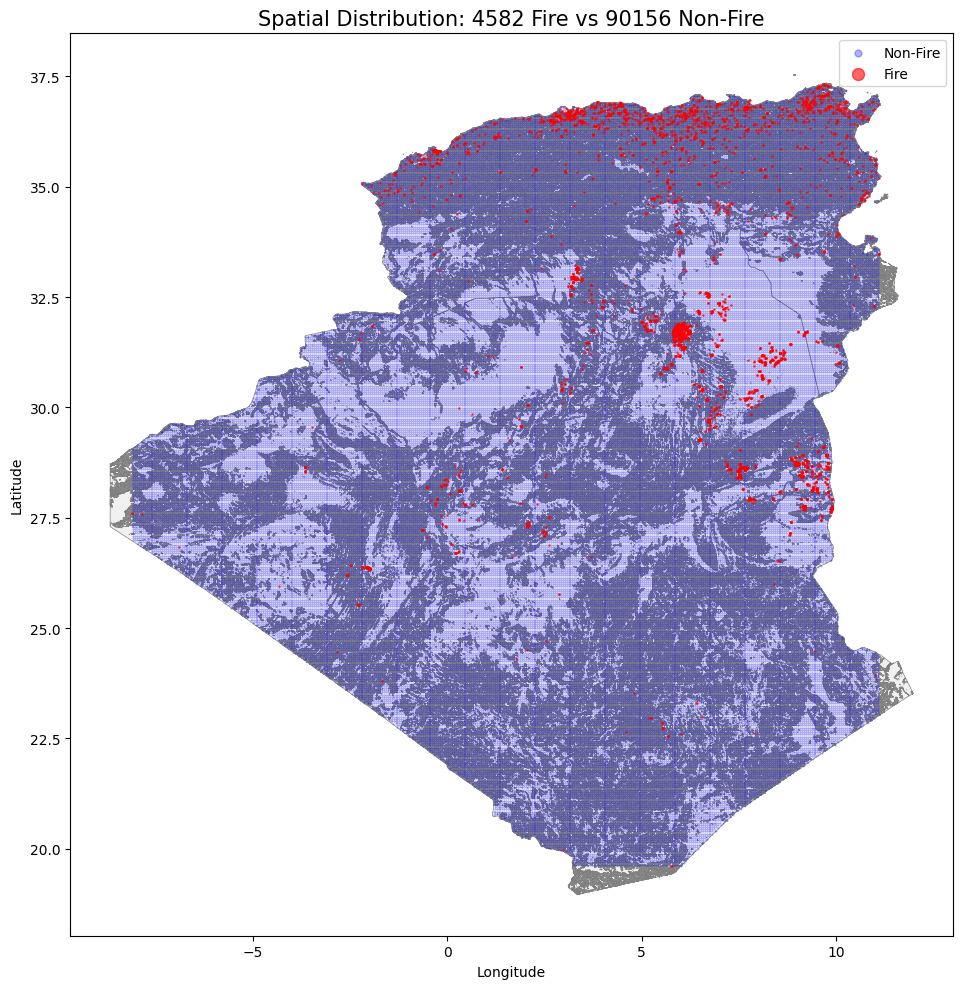

In [30]:
# %%
import matplotlib.pyplot as plt

# 1. Prepare Data
# Assuming your final dataframe is named 'merged' or 'joined'
df_plot = joined.copy() # or merged.copy()

# Split into Fire and Non-Fire for faster batch plotting
fire_points = df_plot[df_plot['fire'] == 1]
non_fire_points = df_plot[df_plot['fire'] == 0]

# 2. Setup Plot
fig, ax = plt.subplots(figsize=(12, 10))

# 3. Plot the Land Background (from your Step 1)
# If 'land' variable is lost, reload it: 
# land = gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp").to_crs(4326)
land.plot(ax=ax, color='#f0f0f0', edgecolor='grey', linewidth=0.5, zorder=1)

# 4. Plot Non-Fire Points (Background layer)
# s=1 (size) and marker='.' are crucial for speed
ax.scatter(
    non_fire_points['longitude'], 
    non_fire_points['latitude'], 
    c='blue', 
    s=1,            # Very small size
    marker='.',     # Simple dot marker (faster than 'o')
    alpha=0.3,      # Transparency to show density
    label='Non-Fire',
    zorder=2,
    rasterized=True # rasterizes points for faster saving/zooming
)

# 5. Plot Fire Points (Foreground layer)
ax.scatter(
    fire_points['longitude'], 
    fire_points['latitude'], 
    c='red', 
    s=3,            # Slightly larger to stand out
    marker='.', 
    alpha=0.6,
    label='Fire',
    zorder=3,
    rasterized=True
)

# 6. Formatting
ax.set_title(f'Spatial Distribution: {len(fire_points)} Fire vs {len(non_fire_points)} Non-Fire', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(markerscale=10) # Make legend dots bigger so they are visible

plt.tight_layout()
plt.show()